In [16]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.deep_learning.soundtype_classifier.classifier_datasets import create_data_for_classifier
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from collections import defaultdict
from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from src.deep_learning.neural_networks.create_conv_model import create_conv_model
from IPython.display import HTML, Javascript, display
from src.visualization.plotting_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


def restart_kernel_and_run_all_cells():
    display(HTML(
        '''
            <script>
                code_show = false;
                function restart_run_all(){
                    IPython.notebook.kernel.restart();
                    setTimeout(function(){
                        IPython.notebook.execute_all_cells();
                    }, 10000)
                }
                function code_toggle() {
                    if (code_show) {
                        $('div.input').hide(200);
                    } else {
                        $('div.input').show(200);
                    }
                    code_show = !code_show
                }
                code_toggle() 
                restart_run_all()
            </script>

        '''
    ))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# What data to use
dates = 'all'
colonies = ['stark', 'lannister', 'martell', 'targaryen', 'baratheon', 'tyrell', 'arryn']
# colonies = ['nmrkleinannotated']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked',]
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']
max_sounds_per_class = {'softchirp': 4000}
max_sound_length = 12000
min_sound_length = 1337
min_sound_occurrences = 30
# Denoising parameters
use_rec_denoising = False
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}
# Sounds metadata parameters
classes_balance_factor = 6/7
train_ratio = .7
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']

# Processing features
extract_specs_params = {'num_freq_bins': 128,
                        'num_time_bins': 64,
                        'nperseg': 512, 
                        'noverlap': None, 
                        'min_freq': 3000,
                        'max_freq': 11025,
                        'spec_min_val': -10, 
                        'spec_max_val': 0,
                        'remove_dc_offset': True, 
                        'mel': False, 
                        'max_dur': 0.4, 
                        'time_stretch': True}
sr = 22050
highpass_filtering = 3000
specs_type = 'new-specs' # 'mel' , 'specs', 'new-specs'
target_shape = (extract_specs_params['num_freq_bins'], extract_specs_params['num_time_bins'])

# Data augmentation parameters
wave_augment_params = {'augment': False, 
                       'times_each_sound': 1, 
                       'stretching_lims': None,
                       'add_noise_lims': (0.001, 0.005), }
times_augment_im = 3
augment_im = True

# Where to store
path_to_save = None
dataset_name = None
seed = np.random.randint(10000000)
path_to_models = PATH_TO_PROJECT + 'models/multi-runs_classifier/nmr/'

data_str = 'berlin'
augment_str = 'no-augment' if (times_augment_im == 1 or not augment_im) else 'im-augment=%d' % times_augment_im

experiment_name = 'seed%s_%s_%s_%s_nfft=%d_shape=%s_denoise=%s_hpass=%s' % (seed, data_str, specs_type,
                                                                            augment_str, 
                                                                            extract_specs_params['nperseg'],
                                                                            target_shape,  use_rec_denoising, 
                                                                            highpass_filtering)
print('Experiment:', experiment_name)

Experiment: seed3496250_berlin_new-specs_im-augment=3_nfft=512_shape=(128, 64)_denoise=False_hpass=3000


In [3]:
# Create config dictionary
all_params_dict = {'sr': sr,
                   
                   'recs_metadata': 
                       {'dates': dates, 'colonies': colonies, 'experiments': experiments, 'stages': stages,
                        'path_to_recordings_metadata': path_to_recordings_metadata, 
                        'recordings_metadata_name': recordings_metadata_name},
                   
                   'rec_denoising':
                       {'use_rec_denoising': use_rec_denoising, 'rec_denoising_params': rec_denoising_params},
                   
                   'sounds_metadata':
                       {'classes_to_drop': classes_to_drop, 'max_sounds_per_class': max_sounds_per_class, 
                        'max_sound_length': max_sound_length, 'min_sound_length': min_sound_length, 
                        'min_sound_occurrences': min_sound_occurrences,
                        'classes_balance_factor': classes_balance_factor, 'train_ratio': train_ratio,
                        'columns_to_copy': columns_to_copy, 'random_seed': seed},
                   
                   'features': 
                       {'target_shape': target_shape, 'highpass_filtering': highpass_filtering,
                        'wave_augment_params': wave_augment_params,  
                        'extract_specs_params': extract_specs_params, 'specs_type': specs_type, 
                        'times_augment_im': times_augment_im, 'augment_im': augment_im}
                  }

In [4]:
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages, {})

Using 904 recordings


Experiment: seed4657505_berlin_new-specs_im-augment=3_nfft=512_shape=(128, 64)_denoise=False_hpass=3000
Using 904 recordings


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(sounds_metadata_balanced, 0)


Using 461 recordings (4465 sounds)for train and  198 recordings (2632 sounds)for test

############ Classes in train:############ 

softchirp      2479
downsweep       455
pupcombo        401
scream          170
whistle         164
combotwo        158
pupcheveron     124
combo           119
grunt           118
loudchirp       104
upsweep          91
pupsquawk        70
hiccup           12
Name: cl, dtype: int64
############ Classes in test: ############ 

softchirp      1518
pupcombo        291
downsweep       290
whistle         151
combo           108
combotwo         87
pupcheveron      54
grunt            39
loudchirp        32
pupsquawk        31
upsweep          20
hiccup           11
Name: cl, dtype: int64
After balancing:
############ Classes in train:############ 

softchirp      2479
downsweep      1820
whistle        1640
pupcheveron    1612
pupcombo       1604
combotwo       1580
loudchirp      1560
combo          1547
grunt          1534
scream         1530
pupsquawk      

/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for sound in sounds_npy_train])
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for sound in sounds_npy_test])
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classifier_datasets.py:108: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'obj

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 64, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 16, 64)        3

2022-06-26 15:54:25.134633: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2062811136 exceeds 10% of free system memory.
2022-06-26 15:54:25.771559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-26 15:54:25.792028: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


Epoch 1/15


2022-06-26 15:54:26.177879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-26 15:54:26.592688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-26 15:54:26.603200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-06-26 15:54:28.365411: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:28.365527: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to custo

2022-06-26 15:54:31.479594: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:31.603882: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:31.743283: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:31.869273: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:34.903642: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:35.026498: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:35.154796: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:35.276766: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:38.439569: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:38.561144: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:38.685488: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:38.809539: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:41.948213: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:42.070599: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:42.198181: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:42.321638: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:45.200436: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:45.322774: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:45.455209: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:45.576832: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:48.714545: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:48.837825: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:48.964901: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:49.089985: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:52.219201: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:52.341505: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:52.467265: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:52.589719: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:55.830824: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:55.953378: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:56.085968: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:56.209939: W tensorflow/stream_executor/gpu/

2022-06-26 15:54:59.450752: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:59.573592: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:59.705269: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:54:59.827796: W tensorflow/stream_executor/gpu/

  2/246 [..............................] - ETA: 14s - loss: 2.5514 - sparse_categorical_accuracy: 0.0693    

2022-06-26 15:55:00.468158: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:00.592153: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



245/246 [============================>.] - ETA: 0s - loss: 1.3716 - sparse_categorical_accuracy: 0.5312

2022-06-26 15:55:14.310592: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:14.440691: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:14.577944: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:14.707657: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:18.128442: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:18.257890: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:18.403696: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:18.533739: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:22.102501: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:22.231525: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:22.375596: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:22.505235: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:25.844286: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:25.973096: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:26.104238: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:26.234371: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:29.662451: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:29.792211: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:29.923733: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:30.052180: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:33.311450: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:33.444151: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:33.577576: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:33.707134: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:37.007412: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:37.136096: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:37.269272: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:37.398307: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:40.704328: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:40.832833: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:40.968567: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:41.097597: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:44.573254: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:44.702577: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:44.885161: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:45.014370: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:48.363574: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:48.492899: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



246/246 [==============================] - ETA: 0s - loss: 1.3696 - sparse_categorical_accuracy: 0.5319

2022-06-26 15:55:48.626798: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:48.756917: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:49.492407: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:49.622770: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:53.013630: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:53.146696: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:53.294047: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:53.426996: W tensorflow/stream_executor/gpu/

2022-06-26 15:55:56.859768: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:56.991403: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:57.125932: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:55:57.257871: W tensorflow/stream_executor/gpu/

2022-06-26 15:56:00.617784: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:56:00.751575: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:56:00.885645: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:56:01.017694: W tensorflow/stream_executor/gpu/

246/246 [==============================] - 99s 261ms/step - loss: 1.3677 - sparse_categorical_accuracy: 0.5325 - val_loss: 0.5391 - val_sparse_categorical_accuracy: 0.8134
Epoch 2/15
  1/246 [..............................] - ETA: 14s - loss: 0.3861 - sparse_categorical_accuracy: 0.8789

2022-06-26 15:56:04.358905: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:56:04.492865: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



246/246 [==============================] - 14s 56ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8806 - val_loss: 0.4452 - val_sparse_categorical_accuracy: 0.8568
Epoch 3/15
246/246 [==============================] - 14s 56ms/step - loss: 0.1954 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.5024 - val_sparse_categorical_accuracy: 0.8545
Epoch 4/15
246/246 [==============================] - 14s 57ms/step - loss: 0.1349 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8739
Epoch 5/15
246/246 [==============================] - 14s 59ms/step - loss: 0.0934 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.5309 - val_sparse_categorical_accuracy: 0.8830
Epoch 6/15
246/246 [==============================] - 14s 58ms/step - loss: 0.0712 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.5939 - val_sparse_categorical_accuracy: 0.8701
Epoch 7/15
246/246 [==============================] - 14s 56ms/step - loss: 0.0677 - sparse_categoric

2022-06-26 15:59:19.879602: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/gr1/Projects/naked-mole-rats/models/multi-runs_classifier/nmr/seed4657505_berlin_new-specs_im-augment=3_nfft=512_shape=(128, 64)_denoise=False_hpass=3000/assets


2022-06-26 15:59:20.776576: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:20.900268: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:21.025360: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:21.147811: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:24.267467: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:24.389716: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:24.515593: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:24.637753: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:27.755772: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:27.878709: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:28.002963: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:28.124487: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:31.229208: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:31.351673: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:31.476889: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:31.598210: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:34.923029: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:35.047312: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:35.173134: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:35.297309: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:38.413822: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:38.536122: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:38.660620: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:38.781788: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:41.884583: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:42.006234: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:42.131558: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:42.253001: W tensorflow/stream_executor/gpu/

2022-06-26 15:59:45.361812: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:45.484551: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:45.610128: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-06-26 15:59:45.732858: W tensorflow/stream_executor/gpu/

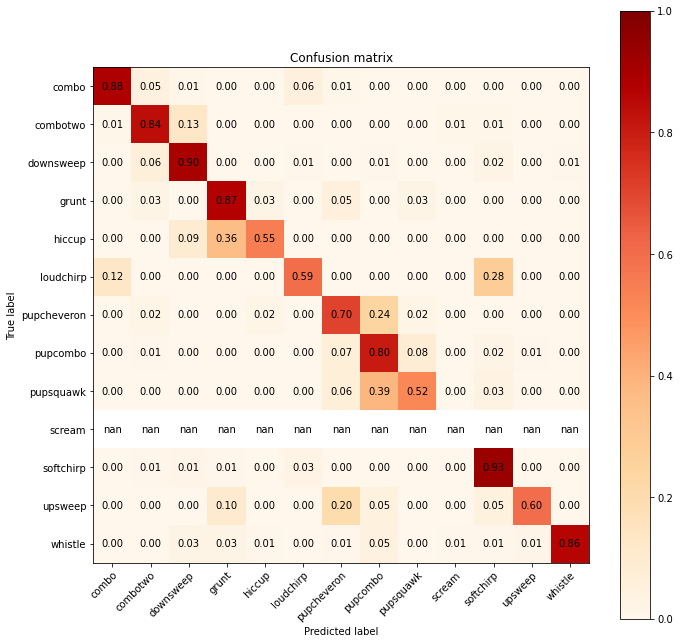

In [5]:
n_runs = 5


seed = np.random.randint(10000000)
experiment_name = 'seed%s_%s_%s_%s_nfft=%d_shape=%s_denoise=%s_hpass=%s' % (seed, data_str, specs_type,
                                                                            augment_str,
                                                                            extract_specs_params['nperseg'],
                                                                            target_shape,  use_rec_denoising, 
                                                                            highpass_filtering)
all_params_dict['sounds_metadata']['random_seed'] = seed
print('Experiment:', experiment_name)

# Create and save datasets
(all_classes, sounds_metadata_train, sounds_npy_train, melspecs_train,  sounds_metadata_test, 
 sounds_npy_test,  melspecs_test) = create_data_for_classifier(all_params_dict, dataset_name, 
                                                               path_to_save, save=False, 
                                                               preloaded_recs_dict=recs_dict)


img_shape = melspecs_train.shape[1:]
y_train_str = sounds_metadata_train['cl']
y_test_str = sounds_metadata_test['cl']
all_classes_str = sorted(list(set(y_train_str.unique()) | set(y_test_str.unique())))
y_train = y_train_str.apply(lambda x: all_classes_str.index(x))
y_test = y_test_str.apply(lambda x: all_classes_str.index(x))

if len(melspecs_train.shape) < 4:
    melspecs_train = melspecs_train.reshape((*melspecs_train.shape, 1))
if len(melspecs_test.shape) < 4:
    melspecs_test = melspecs_test.reshape((*melspecs_test.shape, 1))
with tf.device('/gpu:0'):
    model = create_conv_model(img_shape, all_classes_str)
    epochs = 15
    model.fit(melspecs_train, y_train, epochs=epochs, batch_size=256, validation_data=(melspecs_test, y_test))

model.save(path_to_models + experiment_name)
#y_train_predicted_probs = model.predict(melspecs_train)
#y_train_predicted = np.argmax(y_train_predicted_probs, 1)
y_test_predicted_probs = model.predict(melspecs_test)
y_test_predicted = np.argmax(y_test_predicted_probs, 1)

np.save(path_to_models + experiment_name + '/y_test_predicted_probs.npy', y_test_predicted_probs)
np.save(path_to_models + experiment_name + '/y_test.npy', y_test)
np.save(path_to_models + experiment_name + '/all_classes_str.npy', all_classes_str)

cm = confusion_matrix(y_test, y_test_predicted)
fig = plot_confusion_matrix(cm, all_classes_str,  figsize = (10, 10), cmap=plt.cm.OrRd,
                            normalize=True, clim=(0, 1))
fig.savefig(path_to_models + experiment_name + '/confusion_matrix_test.png')

if len(os.listdir(path_to_models)) < n_runs:
    restart_kernel_and_run_all_cells()

In [6]:
1/0

ZeroDivisionError: division by zero

### Eval (all saved models, not only the last one)

In [8]:
base_path = PATH_TO_PROJECT + 'models/multi-runs_classifier/'
exp_types = os.listdir(base_path)
print(exp_types)

['nmr']


In [22]:
accuracies_dict = defaultdict(list)
confusion_matrices_dict = defaultdict(list)
exp = exp_types[0]
path_to_models = base_path + exp + '/'
for f in os.listdir(path_to_models):
    y_test_predicted_probs = np.load(path_to_models + f + '/y_test_predicted_probs.npy')
    y_test = np.load(path_to_models + f + '/y_test.npy')
    cm = confusion_matrix(y_test, np.argmax(y_test_predicted_probs, 1))
    y_test_predicted = np.argmax(y_test_predicted_probs, 1)
    y_test = np.load(path_to_models + f + '/y_test.npy')
    all_classes_str = np.load(path_to_models + f + '/all_classes_str.npy')
    type_of_specs = 'new-specs' if 'new-specs' in f else 'mel-specs'
    run_code = '%s-%s' % (exp, type_of_specs)
    accuracies_dict[run_code].append((y_test_predicted == y_test).mean())
    confusion_matrices_dict[run_code].append(cm)

In [25]:
for cm in confusion_matrices_dict[run_code]:
    print(cm.shape)

(13, 13)
(13, 13)
(13, 13)
(13, 13)
(13, 13)


In [18]:
x = []
y_mean = []
y_std = []
for run_name, accs in accuracies_dict.items():
    x.append(run_name)
    y_mean.append(np.mean(accs))
    y_std.append(np.std(accs))

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  import sys


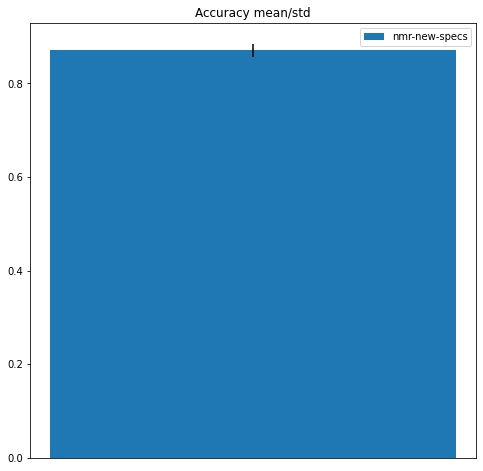

In [13]:
plt.figure(figsize=(8, 8))
for i in range(len(x)):
    plt.bar(x[i], y_mean[i], label=x[i])
    plt.errorbar(x[i], y_mean[i], yerr = y_std[i], fmt='',ecolor = 'black', color='white')
    #plt.xlim(0.9, 1.1)
    plt.title('Accuracy mean/std')
_ = plt.xticks([])
_ = plt.legend()